In [226]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


В работе используется датасет: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

Он содержит информацию о состоянии, возрасте, положении пациентов, а также о факте инсульта.

Аттрибуты
1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not

In [227]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

Проведем предобработку данных:
- Удалим NaN значения
- Удалим дубликаты
- Удалим выбросы
- Избавимся от кривых и лишних данных

Добавим новый аттрибут в-фактор, который вычисляется по столбцам heart_disease, stroke и age

In [228]:
df = df.dropna()
df = df.drop_duplicates()

df = df.drop(columns=['id'])
df = df.drop(df[df['gender'] == 'Other'].index)

factor = 'v_factor'
df[factor] = (df['heart_disease'] + df['stroke']) * df['age']
targets = ['age', 'avg_glucose_level', 'bmi']


In [229]:
def remove_outliers(df, quantiles=(0.2, 0.8)):
    numeric_columns = df.select_dtypes(include=[np.number]).columns

    # Remove outliers from each numeric column
    for column in numeric_columns:
        q1, q3 = df[column].quantile(quantiles)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df = df[(df[column] > lower_bound) & (df[column] < upper_bound)]

    return df

remove_outliers(df)

df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,v_factor
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,134.0
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,160.0
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,49.0
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,79.0
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1,81.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5104,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0,0.0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0,0.0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0,0.0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0,0.0


Построим графики зависимостей в-фактора от выбранных показателей.
На каждом из графиков наблюдаются четко выраженные группы.

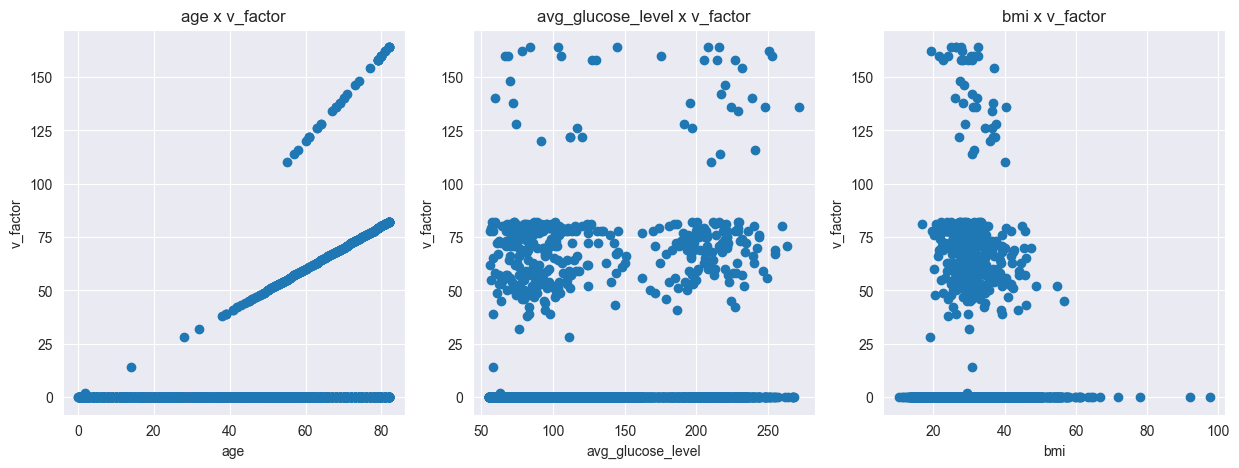

In [230]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

def scatter(first, second, plotIdx):
    axes[plotIdx].scatter(df[first], df[second])
    axes[plotIdx].set_title(f'{first} x {second}')
    axes[plotIdx].set_xlabel(first)
    axes[plotIdx].set_ylabel(second)

scatter(targets[0], factor, 0)
scatter(targets[1], factor, 1)
scatter(targets[2], factor, 2)

plt.show()

Воспользуемся методом локтя для определения подходящего количества кластеров.
Определять кластеры будем по инерции.
Так можно получить следующее оптимальное количество кластеров:
age x v_factor : 3
avg_glucose_level x v_factor : 2
bmi x v_factor : 2

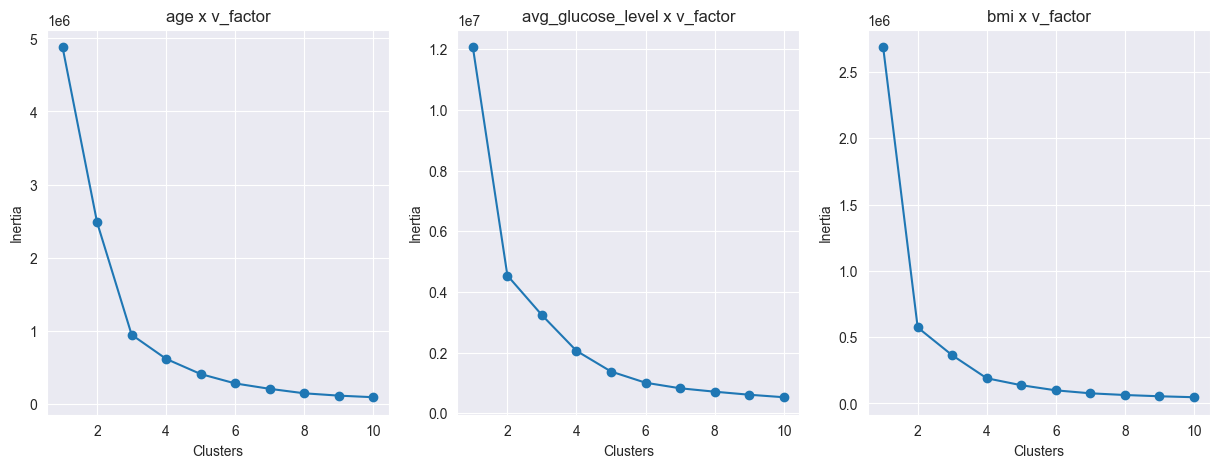

In [231]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

def kmeans(first, second, plotIdx):
    inertia = []
    for k in range(1, 11):
        inertia.append(KMeans(n_clusters=k, n_init=10, random_state=0).fit(df[[first, second]]).inertia_)

    axes[plotIdx].plot(range(1, 11), inertia, marker='o')
    axes[plotIdx].set_title(f'{first} x {second}')
    axes[plotIdx].set_xlabel('Clusters')
    axes[plotIdx].set_ylabel('Inertia')

kmeans(targets[0], factor, 0)
kmeans(targets[1], factor, 1)
kmeans(targets[2], factor, 2)

Визуализируем найденные кластеры с помощью kmeans. Будем использовать оптимальное количество кластеров полученное на предыдущем пункте.

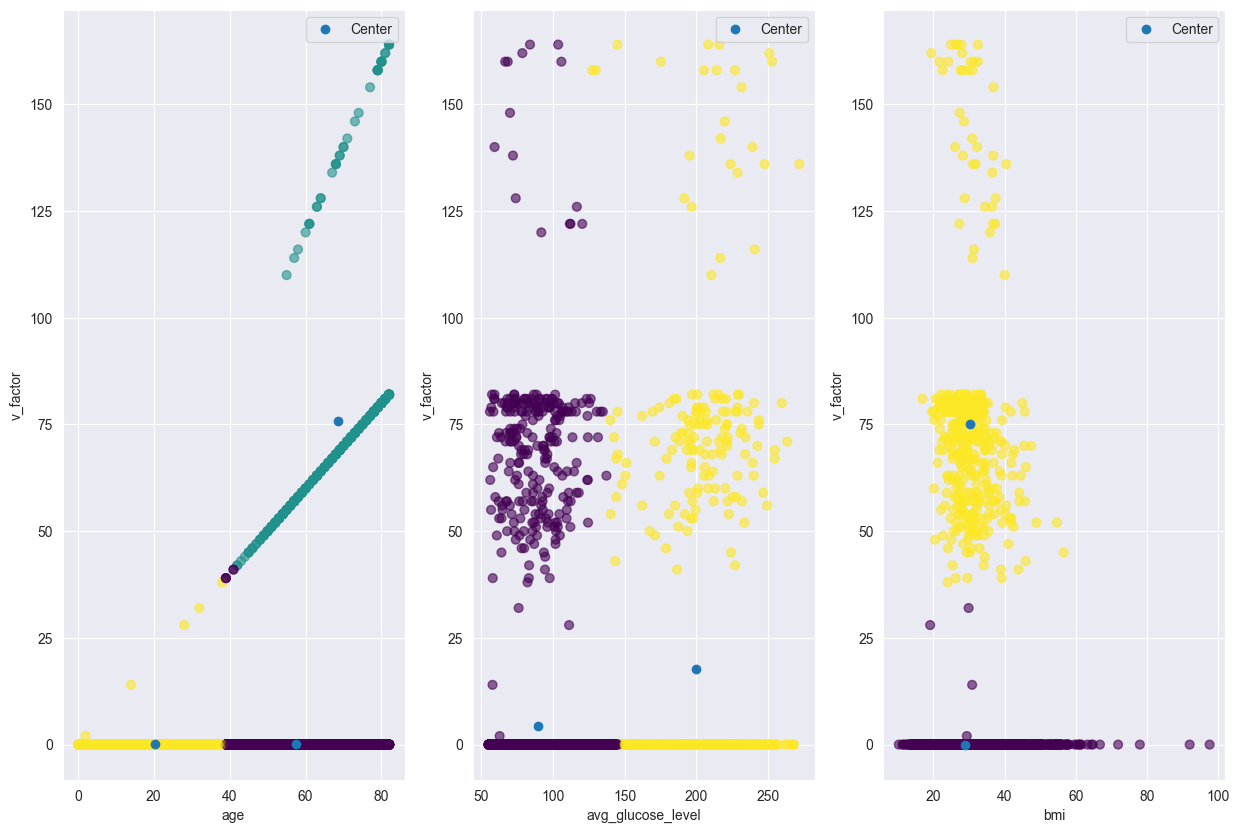

In [232]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

def clusters(n_clusters, first, second, plotIdx):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(df[[first, second]])
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    axes[plotIdx].scatter(df[first], df[second], c=labels, cmap='viridis', s=40, alpha=0.6)
    axes[plotIdx].scatter(centers[:, 0], centers[:, 1], label='Center')
    axes[plotIdx].set_xlabel(first)
    axes[plotIdx].set_ylabel(second)
    axes[plotIdx].legend()

clusters(3, targets[0], factor, 0)
clusters(2, targets[1], factor, 1)
clusters(2, targets[2], factor, 2)

В данной работе был проведен ряд шагов для анализа данных:

1. Предварительная обработка данных
"Причесывание" данных является существенным этапом, который очищает данные от ошибок и несоответствий, создавая более надежный и точный набор данных для последующего анализа.

2. Визуализация данных
Графики помогают выявлять зависимости в данных и визуально определять кластеры. 
Они улучшают понимание структуры данных и облегчают обнаружение закономерностей.

3. Анализ с помощью KMeans
Метод KMeans позволяет проводить углубленный анализ данных путем группировки их в отдельные кластеры. 
Изучение характеристик этих кластеров обеспечивает ценные сведения о структуре и взаимосвязях в данных.

4. Использование дополнительных атрибутов
Добавление новых атрибутов расширяет данные и улучшает их информативность, обеспечивая основу для более глубокого и целостного анализа.